# OLG model with transition

This code is based on Heer and Maussner(2008). 

In [1]:
using Plots
gr()

Plots.GRBackend()

In [2]:
mutable struct Model{TI<:Integer, TF<:AbstractFloat}
    
    #primitive params
    β::TF # subjective discount factor
    γ::TF # share of working 
    η::TF # relative risk aversion
    ψ::TF # params for utility
    α::TF # capital share
    δ::TF # depriciation rate
    
    # asset grid
    agrid::Array{TF,1}

    # age settings
    T::TI # working periods
    TR::TI # retired periods
    
    #distribution
    mass::Array{TF,1}
    
    # iteration settings
    tol::TF
    maxiter::TI
    
    # transition periods
    TC::TI
end

In [3]:
function Construct( β = 0.9,
                    γ = 2.0,
                    η = 2.0,
                    ψ = 0.001,
                    α = 0.3,
                    δ = 0.4)

    # asset grid
    const amin = 1e-10
    const amax = 5.0
    const na = 10000
    const disa  = (amax-amin)/(na-1)^2;	# distance between points
    temp   = collect(linspace(1,na,na))              
    aux = convert(Array{Int64,1},temp)
    agrid = amin + disa*(aux-1).^2
    # age
    T = 4
    TR = 2
    
    # mass
    mass = ones(T+TR)/(T+TR)
    
    # iteration settings
    tol = 1e-4
    maxiter = 100
    
    # transition periods
    TC = 3*(T+TR)
   
    return m = Model(β,γ,η,ψ,α,δ,agrid,T,TR,mass,tol,maxiter,TC)
end

Construct (generic function with 7 methods)

In [4]:
function Compute_trans(m::Model,rep0,K0,L0,rep1,K1,L1)
    
    # for convenience
    const TC = m.TC
    const TR = m.TR
    const T  = m.T
    const α = m.α
    const δ = m.δ
    # initial guess for aggregate variables paths.
    Kt = collect(linspace(K0,K1,TC))
    Lt = collect(linspace(L0,L1,TC))
    # preallocate prices paths
	wt = zeros(TC+2*(T+TR-1))
	rt = zeros(TC+2*(T+TR-1))
	bt = zeros(TC+2*(T+TR-1))
	τt = zeros(TC+2*(T+TR-1))
    
    # prealocate prices and quantities paths that agents face in their life time.
	wc   = zeros(T)
	τc  = zeros(T)
	rc   = zeros(T+TR)
	bc   = zeros(TR)
    
    kc = zeros(TC+T+TR-1,TC+2*(T+TR-1)) 
    #row is time(t=1:tc+2*(T+TR-1)), colum is time when geneation born.
	lc = zeros(TC+T+TR-1,TC+2*(T+TR-1))
    Knew = zeros(TC)
	Lnew = zeros(TC)
    
    # compute prices on the both SSs
    @inbounds for i in 1 : T+TR-1
    	wt[i] = (1.0-α)*((K0/L0)^α)#m.F_to_w(K0,L0)
        rt[i] = α*((L0/K0)^(1.0-α)) -δ #m.F_to_r(K0,L0)
    	τt[i] = (TR*rep0)/(T+TR*rep0) #compute  goverment budget and definition of replacement rate
    	bt[i] = ((T+TR)/TR)*τt[i]*wt[i]*L0;
	end
    
    @inbounds for i in TC+T+TR : TC+2*(T+TR-1)
    	wt[i] = (1.0-α)*((K1/L1)^α)
        rt[i] = α*((L1/K1)^(1.0-α)) -δ 
    	τt[i] = (TR*rep1)/(T+TR*rep1) #compute  goverment budget and definition of replacement rate
    	bt[i] = ((T+TR)/TR)*τt[i]*wt[i]*L1
	end
    

    for iter in 1: m.maxiter    
        
        # since transition path is altered, we have to update prices paths.
        @inbounds for i in T+TR : TC+T+TR-1
            wt[i] = (1.0-α)*((Kt[i-(T+TR-1)]/Lt[i-(T+TR-1)])^α)
            rt[i] = α*(Lt[i-(T+TR-1)]/Kt[i-(T+TR-1)])^(1.0-α) -δ 
            τt[i] = (TR*rep1)/(T+TR*rep1) #compute  goverment budget and definition of replacement rate
            bt[i] = ((T+TR)/TR)*τt[i]*wt[i]*Lt[i-(T+TR-1)]
        end
        
        # compute k and n for each generation
        @inbounds for i in 1 : TC+T+TR-1 # model periods when generation i is born.
            @inbounds for j in 1 : T+TR # agents age
                rc[j] = rt[i+j-1]
                if j <= T
                    wc[j]  = wt[i+j-1]
                    τc[j] = τt[i+j-1]
                end
                if  j <=TR
                    bc[j] = bt[i+j+T-1]
                end
            end	

            k_compute,l_compute = HH_trans(m,τc,wc,rc,bc)
            @inbounds for j in 1 : T+TR
                kc[i,i+j-1] = k_compute[j]
                if j <= T
                    lc[i,i+j-1] = l_compute[j]
                end
            end
        end 
            # compute new aggregate K and N
            @inbounds for i in T+TR : TC+T+TR-1
                @views Knew[i-(T+TR-1)] = (1.0/(T+TR))*sum(kc[:,i]) #dot(m.mass, kc[:,i])
                @views Lnew[i-(T+TR-1)] = (1.0/(T+TR))*sum(lc[:,i])
            end
        
        err_k = maximum(abs.(Knew- Kt))
        err_l = maximum(abs.(Lnew- Lt))
        err = max(err_k,err_l)
    
        # update guess
        Kt = 0.75*Knew + 0.25*Kt 
        Lt = 0.75*Lnew + 0.25*Lt

        if err < m.tol
            break
        end
    end

    return Knew, Lnew
end

Compute_trans (generic function with 1 method)

In [5]:
function HH_trans(m::Model,τc,wc,rc,bc)
    
    # unpack params
    const β = m.β
    const γ = m.γ
    const η = m.η
    const ψ = m.ψ
    const α = m.α
    const δ = m.δ
    agrid = m.agrid
    const na = size(agrid,1)
    const T = m.T 
    const TR = m.TR
    mass = m.mass
    const tol = m.tol
    const maxiter = m.maxiter
    const neg = -1e10 # huge negative number
    
    # preallocate 
    v::Array{Float64,2} = zeros(na,T+TR)
    pol_lab::Array{Float64,2} = zeros(na,T)
    a_index::Array{Int64,2} = ones(na,T+TR)

    kgen::Array{Float64,1} = zeros(T+TR)
    labgen::Array{Float64,1} = zeros(T)
    

    # solve indivisual problem by backward induction
    # utility in the last period
    for ia0 in 1:na
        @inbounds cons = (1.0+rc[T+TR])*agrid[ia0] + bc[TR]
        @inbounds v[ia0,T+TR] = ((cons+ψ)^(1.0-η) -1.0)/(1.0-η)
    end
         
    @inbounds for j in T+TR-1:-1:T+1
        gridstart::Int64=1
        @inbounds for ia0 in 1: na
            vmin = neg 
            @inbounds for ia1 in gridstart:na
                cons = (1.0+rc[j])*agrid[ia0] +bc[j-T] - agrid[ia1]
                if cons <= 0.0
                    util = neg        
                else
                    util = ((cons+ψ)^(1.0-η) -1.0)/(1.0-η)
                end
                v0 = util + β* v[ia1,j+1]
                    
                if v0 > vmin
                    gridstart = ia1
                    vmin = v0
                else
                    break
                end
            end
            v[ia0,j] = vmin
            a_index[ia0,j] =gridstart
        end
    end
        
    @inbounds for j in T:-1:1
        gridstart::Int64 =1
        @inbounds for ia0 in 1 : na
            vmin = neg
            temp = ((1-τc[j])*wc[j] - (1+rc[j])*agrid[ia0]*γ  - ψ*γ)
            saving = (1.0+rc[j])*agrid[ia0]
            @inbounds for ia1 in gridstart: na
                lab = (temp +agrid[ia1]*γ)/((1.0-τc[j])*(1.0+γ)*wc[j])
                #((1-τc[j])*wc[j] - (1+rc[j])*agrid[ia0]*γ + agrid[ia1]*γ - ψ*γ)
                #/((1.0-τc[j])*(1.0+γ)*wc[j])
                
                # fesibility
                if lab <0.0
                    lab = 0.0
                elseif lab > 1.0
                    lab = 1.0
                end
                    
                cons = saving + (1.0-τc[j])*wc[j]*lab - agrid[ia1]
                    
                if cons <= 0.0
                    util = neg
                elseif lab ==1.0
                    util = neg
                else
                    util = (((cons+ψ)*(1.0-lab)^γ)^(1.0-η) -1.0)/(1.0-η) 
                end
                    
                v0 = util + β*v[ia1,j+1]
                if v0 > vmin
                    pol_lab[ia0,j] = lab
                    gridstart= ia1
                    vmin = copy(v0)
                else
                    break
                end
            end
            v[ia0,j] = copy(vmin)
            a_index[ia0,j] = copy(gridstart)
        end
    end
 
        # calculate asset holdings and labor supply for each generation
    ia0 = 1
    for j in 1:T+TR-1
        ia1 = a_index[ia0,j]
        @inbounds kgen[j+1] = agrid[ia1]
        if j <= T
           @inbounds labgen[j] = @views pol_lab[ia0,j]
        end
        ia0 = ia1
    end
    
    return kgen, labgen
end  

HH_trans (generic function with 1 method)

In [6]:
function Compute_SS(m::Model, rep)

    # unpack params
    const β = m.β
    const γ = m.γ
    const η = m.η
    const ψ = m.ψ
    const α::Float64 = m.α
    const δ::Float64 = m.δ
    agrid = m.agrid
    const na = size(agrid,1)
    const T = m.T 
    const TR = m.TR
    mass = m.mass
    const tol = m.tol
    const maxiter = m.maxiter
    const τ = (TR*rep)/(T+TR*rep)
    const neg = -1e10 # huge negative number
    
    # preallocate 
    v::Array{Float64,2} = zeros(na,T+TR)
    pol_lab::Array{Float64,2} = zeros(na,T)
    a_index::Array{Int64,2} = ones(na,T+TR) 
    kgen::Array{Float64,1} = zeros(T+TR)
    labgen::Array{Float64,1} = zeros(T)
    
    # initial guess
    L0     = 0.2
    K0     = 0.56

    for iter in 1: maxiter
        w0 = (1.0-α)*((K0/L0)^α)#m.F_to_w(K0,L0)
        r0 = α*((L0/K0)^(1.0-α)) -δ #m.F_to_r(K0,L0)
        b = ((T+TR)/TR)*τ*w0*L0
         
        # solve indivisual problem by backward induction
        # utility in the last period
        @inbounds for ia0 in 1:na
            cons = (1.0+r0)*agrid[ia0] + b
            v[ia0,T+TR] = ((cons+ψ)^(1.0-η) -1.0)/(1.0-η) 
        end
         
        @inbounds for j in T+TR-1:-1:T+1
            gridstart::Int64=1
            @inbounds for ia0 in 1: na
                vmin = neg 
                #temp = (1.0+r0)*agrid[ia0] +b
                @inbounds for ia1 in gridstart:na
                    #cons  = temp - agrid[ia1] 
                    cons = (1.0+r0)*agrid[ia0] +b - agrid[ia1]
                    
                    if cons <= 0.0
                        util = neg        
                    else
                        util= ((cons+ψ)^(1.0-η) -1.0)/(1.0-η)
                    end
                    v0 = util + β* v[ia1,j+1]
                    
                    if v0 > vmin
                        gridstart = ia1
                        vmin = v0
                    else
                        break
                    end
                end
                v[ia0,j] = vmin
                a_index[ia0,j] =gridstart
            end
        end
        
        den = ((1.0-τ)*(1.0+γ)*w0)
        tmp = ( (1.0-τ)*w0 - ψ*γ) 
        
        @inbounds for j in T:-1:1
            gridstart::Int64 =1
            @inbounds for ia0 in 1 : na
                vmin = neg
                temp = tmp  - (1.0+r0)*agrid[ia0]*γ
                #saving::Float64 =(1.0+r0)*agrid[ia0] 
               
                @inbounds for ia1 in gridstart: na
                    lab  = (temp +  agrid[ia1]*γ)/den
                    #((1.0-τ)*w0 - (1.0+r0)*agrid[ia0]*γ + agrid[ia1]*γ - ψ*γ)/((1.0-τ)*(1.0+γ)*w0)
                    # fesibility
                    if lab >1.0
                        lab = 1.0
                    elseif lab < 0.0
                        lab = 0.0
                    end
                    
                    #cons::Float64 = saving + wage_tax*lab - agrid[ia1]
                    cons = (1.0+r0)*agrid[ia0] + (1.0-τ)*w0*lab - agrid[ia1]
                    
                    if cons <= 0.0
                        util = neg
                    elseif lab == 1.0
                        util = neg
                    else
                        util = (((cons+ψ)*(1.0-lab)^γ)^(1.0-η) -1.0)/(1.0-η) 
                    end
                    
                    v0 = util + β*v[ia1,j+1]
                    if v0 > vmin
                        gridstart = ia1
                        vmin = v0
                        pol_lab[ia0,j] = lab
                    else
                        break
                    end
                end
                v[ia0,j] = vmin
                a_index[ia0,j] = gridstart
            end
        end
        
        # calculate asset holdings and labor supply for each generation
        ia0 = 1
        @inbounds for j in 1:T+TR
            ia1 = a_index[ia0,j]
            kgen[j] = agrid[ia1]
            if j <= T
                labgen[j] = pol_lab[ia0,j]
            end
            ia0 = ia1
        end
        
        # aggregation
        K1 = dot(kgen,mass)
        @views L1 = dot(labgen,mass[1:T])
        
        # update error 
        err_k =  abs(K0-K1)
        err_lab = abs(L0-L1)
        err = max(err_k,err_lab)
        
        # update initial guess
        K0 = 0.5*K0 + 0.5*K1
        L0 = 0.5*L0 + 0.5*L1
        
        if err < tol 
            break
        end

        if iter == maxiter
            println("the model cannot converge in $maxiter times iteration")
        end
    end
        
    return K0, L0
end

Compute_SS (generic function with 1 method)

In [7]:
function main()
    
    # save main params 
    m = Construct()
    # set replacement ratio
    rep0 = 0.3
    rep1 = 0.2
    # compute steady state
    K0,L0 = Compute_SS(m, rep0) # initial ss
    K1,L1 = Compute_SS(m, rep1) # new ss
    
    
    Kpath, Lpath = Compute_trans(m,rep0,K0,L0,rep1,K1,L1)
    
    result_L = zeros(m.TC+2*(m.T+m.TR-1))
    result_K = zeros(m.TC+2*(m.T+m.TR-1))
    
    temp1 = L0 * ones(m.T+m.TR-1)
    temp2 = L1 * ones(m.T+m.TR-1)
    temp3 = K0 * ones(m.T+m.TR-1)
    temp4 = K1 * ones(m.T+m.TR-1)
    
    result_L[1:m.T+m.TR-1] = temp1
    result_L[m.T+m.TR:m.T+m.TR+m.TC-1] =Lpath 
    result_L[m.T+m.TR+m.TC:end] = temp2
 
    result_K[1:m.T+m.TR-1] = temp3
    result_K[m.T+m.TR:m.T+m.TR+m.TC-1] =Kpath 
    result_K[m.T+m.TR+m.TC:end] = temp4
        
    return result_K, result_L
end 

main (generic function with 1 method)

In [8]:
Kpath, Lpath = main()

([0.0589505, 0.0589505, 0.0589505, 0.0589505, 0.0589505, 0.0616187, 0.0631367, 0.0643993, 0.0652904, 0.0658441  …  0.0665134, 0.0665084, 0.0665286, 0.0665522, 0.0665522, 0.0665251, 0.0665251, 0.0665251, 0.0665251, 0.0665251], [0.227752, 0.227752, 0.227752, 0.227752, 0.227752, 0.234503, 0.233926, 0.233418, 0.233123, 0.233279  …  0.233338, 0.233334, 0.23333, 0.233273, 0.233245, 0.233341, 0.233341, 0.233341, 0.233341, 0.233341])

In [9]:
@time main()

  1.409756 seconds (1.67 k allocations: 196.946 MiB, 4.27% gc time)


([0.0589505, 0.0589505, 0.0589505, 0.0589505, 0.0589505, 0.0616187, 0.0631367, 0.0643993, 0.0652904, 0.0658441  …  0.0665134, 0.0665084, 0.0665286, 0.0665522, 0.0665522, 0.0665251, 0.0665251, 0.0665251, 0.0665251, 0.0665251], [0.227752, 0.227752, 0.227752, 0.227752, 0.227752, 0.234503, 0.233926, 0.233418, 0.233123, 0.233279  …  0.233338, 0.233334, 0.23333, 0.233273, 0.233245, 0.233341, 0.233341, 0.233341, 0.233341, 0.233341])

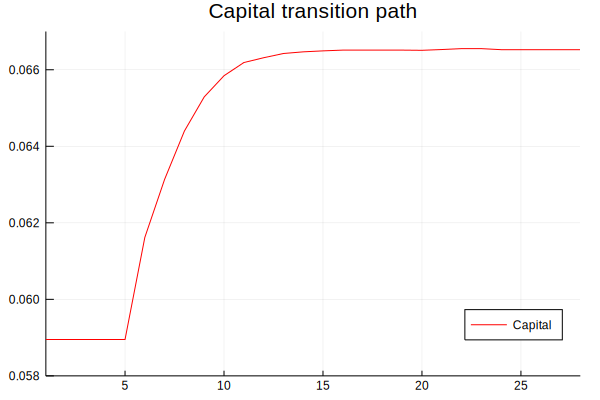

In [10]:
plot(Kpath,label="Capital",legend=:bottomright,color="red")
ylims!(0.058, 0.067)
title!("Capital transition path")

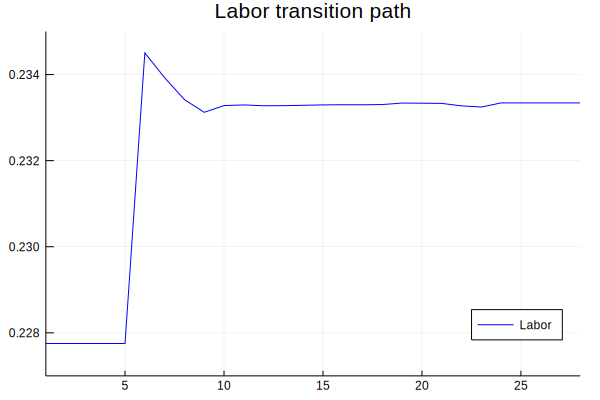

In [11]:
plot(Lpath,label="Labor",legend=:bottomright,color="blue")
ylims!(0.227, 0.235)
title!("Labor transition path")